In [21]:
import numpy as np
import pandas as pd
from pathlib import Path

EMBED_ROOT = Path("/vol/biomedic3/data/EMBED")

In [22]:
# Need instance number for our specific  casewise aggregation methodologies
full_dicom = pd.read_csv(
    EMBED_ROOT / "tables/EMBED_OpenData_metadata.csv", low_memory=False
)[
    [
        "InstanceNumber",
        "anon_dicom_path",
        "PixelSpacing",
        "ImagerPixelSpacing",
        "Rows",
        "Columns",
    ]
]

In [23]:
dicom = pd.read_csv(
    EMBED_ROOT / "tables/EMBED_OpenData_metadata_reduced.csv", low_memory=False
)
print(len(dicom))
dicom = dicom.merge(full_dicom, on="anon_dicom_path")
print(len(dicom))
dicom["image_path"] = (
    dicom["empi_anon"].astype("str")
    + "/"
    + dicom["anon_dicom_path"].str.split("/").str[-1].str.split(".dcm").str[0]
    + ".png"
)

480323
480323


In [24]:
# XCCL shouldn't be converted to CC so manually editing it
dicom.loc[
    (dicom["SeriesDescription"] == "RXCCL") | (dicom["SeriesDescription"] == "LXCCL"),
    "ViewPosition",
] = "XCCL"

# Getting all rows with "ViewPosition" == Nan (but for which SeriesDescription is also not nan, as these are the ones subject to the data entry error)
view_nan = dicom.loc[
    (dicom.ViewPosition.isna()) & (dicom.SeriesDescription.isna() == False)
]

# Drop these rows from
dicom_no_nans = dicom[~dicom.index.isin(view_nan.index)]

view_nan["ViewPosition"] = view_nan["SeriesDescription"].apply(
    lambda x: "CC" if "CC" in x else ("MLO" if "MLO" in x else None)
)

dicom = pd.concat([dicom_no_nans, view_nan], axis=0, ignore_index=True)

/tmp/ipykernel_1882626/3027192612.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  view_nan["ViewPosition"] = view_nan["SeriesDescription"].apply(


In [25]:
print(len(dicom))
# Remove any duplicated images
dicom = dicom.drop_duplicates(subset="anon_dicom_path")
# Remove spot compressed and magnified images
dicom = dicom[dicom.spot_mag.isna()]
# Remove invalid views
dicom = dicom[dicom.ViewPosition.isin(["CC", "MLO"])]
# Remove images from male clients
dicom = dicom[dicom.PatientSex == "F"]
print(len(dicom))

480323
420457


In [9]:
# Remove any unnecessary fields from the DICOM imagewise dataframe (this may need to be updated in the future if other fields are deemed relevant)


dicom = dicom[
    [
        "empi_anon",
        "acc_anon",
        "image_path",
        "FinalImageType",
        "ImageLateralityFinal",
        "ViewPosition",
        "Manufacturer",
        "ManufacturerModelName",
    ]
]

In [10]:
# Conversion dictionary to standardised naming of various fields in clincial metadata

# Human reader BIRADS density assessment
dens_conversion = {1.0: "A", 2.0: "B", 3.0: "C", 4.0: "D"}

In [11]:
# Load in the clinical metadata
mag = pd.read_csv(EMBED_ROOT / "tables/EMBED_OpenData_clinical.csv", low_memory=False)
print(len(mag))
# Remove cases from cases a valid BIRADS density assessment
mag = mag[mag.tissueden.isin([1.0, 2.0, 3.0, 4.0])]
mag.replace({"tissueden": dens_conversion}, inplace=True)

81776


In [12]:
# Keep important study metadata tags to join up with final aggregated dataframe at end of script
mag = mag[["empi_anon", "tissueden", "study_date_anon", "acc_anon"]].drop_duplicates(
    subset="acc_anon"
)
print(len(mag))

72188


In [13]:
# Convert to pandas datetime object
mag["study_date_anon"] = pd.to_datetime(mag["study_date_anon"], errors="coerce")

In [14]:
dicom.Manufacturer.value_counts()

Manufacturer
HOLOGIC, Inc.           386257
GE MEDICAL SYSTEMS       25569
FUJIFILM Corporation      8133
GE HEALTHCARE              498
Name: count, dtype: int64

In [15]:
# Only consider studies which have a valid link between the DICOM and clinical metadata
print(len(dicom))
df = mag.merge(dicom, on="acc_anon")
print(len(df))

420457
418819


In [16]:
df.columns

Index(['empi_anon_x', 'tissueden', 'study_date_anon', 'acc_anon',
       'empi_anon_y', 'image_path', 'FinalImageType', 'ImageLateralityFinal',
       'ViewPosition', 'Manufacturer', 'ManufacturerModelName'],
      dtype='object')

In [17]:
df.to_csv('joined_simple.csv', index=False)

In [18]:
import pandas as pd
df = pd.read_csv("embed_csv.csv")


In [19]:
df.columns

Index(['empi_anon_x', 'tissueden', 'study_date_anon', 'acc_anon',
       'empi_anon_y', 'image_path', 'FinalImageType', 'ImageLateralityFinal',
       'ViewPosition', 'Manufacturer', 'ManufacturerModelName'],
      dtype='object')

In [20]:
df.head()

,empi_anon_x,tissueden,study_date_anon,acc_anon,empi_anon_y,image_path,FinalImageType,ImageLateralityFinal,ViewPosition,Manufacturer,ManufacturerModelName
0,60696029,C,2013-12-30,8099128854014801,60696029,60696029/1.2.826.0.1.3680043.8.498.57863081415...,2D,R,MLO,"HOLOGIC, Inc.",Selenia Dimensions
1,60696029,C,2013-12-30,8099128854014801,60696029,60696029/1.2.826.0.1.3680043.8.498.34391769880...,2D,R,MLO,"HOLOGIC, Inc.",Selenia Dimensions
2,60696029,C,2013-12-30,8099128854014801,60696029,60696029/1.2.826.0.1.3680043.8.498.98599453977...,2D,R,CC,"HOLOGIC, Inc.",Selenia Dimensions
3,90986305,C,2013-08-26,5156106114290009,90986305,90986305/1.2.826.0.1.3680043.8.498.41500728563...,2D,L,MLO,"HOLOGIC, Inc.",Selenia Dimensions
4,90986305,C,2013-08-26,5156106114290009,90986305,90986305/1.2.826.0.1.3680043.8.498.12917616441...,2D,L,CC,"HOLOGIC, Inc.",Selenia Dimensions


In [35]:
df2 = df["empi_anon_x"] == df["empi_anon_y"]

In [36]:
df["ManufacturerModelName"].value_counts()

ManufacturerModelName
Selenia Dimensions                        374192
Senographe Essential VERSION ADS_53.40     12209
Senograph 2000D ADS_17.4.5                 11662
Lorad Selenia                              10515
Clearview CSm                               8128
Senograph 2000D ADS_17.5                    1606
Senographe Pristina                          498
Senographe Essential VERSION ADS_54.10         9
Name: count, dtype: int64

In [34]:
percentage_split = (
    df.groupby("ManufacturerModelName")["tissueden"]
    .value_counts(normalize=True)
    .unstack(fill_value=0) * 100
)

print(percentage_split.round(2))  # Optional: round to 2 decimals


tissueden                                   A      B      C      D
ManufacturerModelName                                             
Clearview CSm                            8.66  45.82  40.81   4.71
Lorad Selenia                            8.88  44.90  43.40   2.82
Selenia Dimensions                      11.73  41.63  40.96   5.68
Senograph 2000D ADS_17.4.5               2.21  46.27  47.62   3.89
Senograph 2000D ADS_17.5                 3.30  41.16  49.38   6.16
Senographe Essential VERSION ADS_53.40   8.05  52.44  37.06   2.44
Senographe Essential VERSION ADS_54.10  55.56   0.00  44.44   0.00
Senographe Pristina                     11.24  29.92  46.39  12.45


Model: Clearview CSm


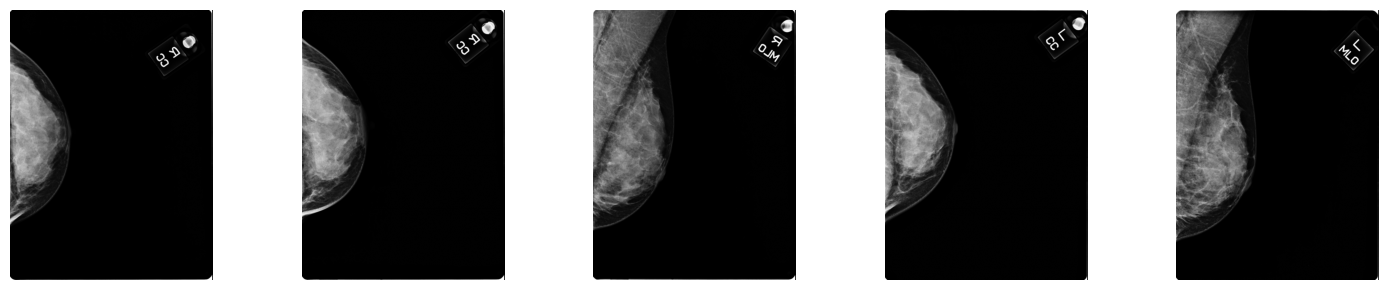

Model: Lorad Selenia


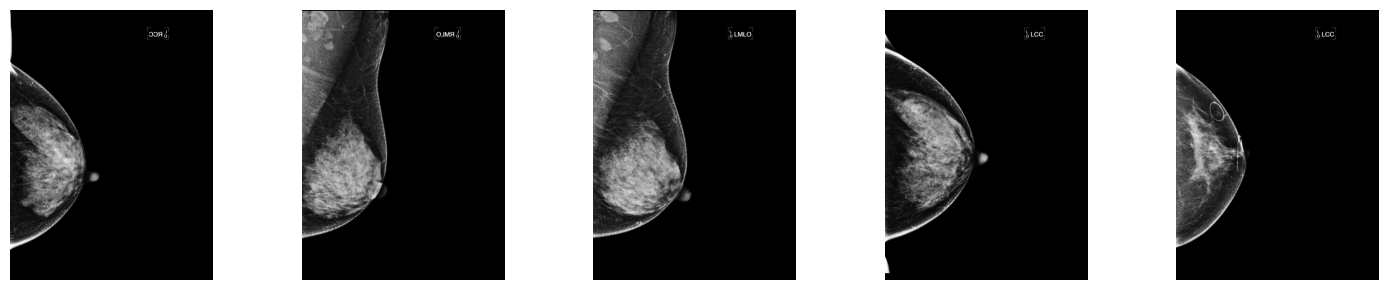

Model: Selenia Dimensions


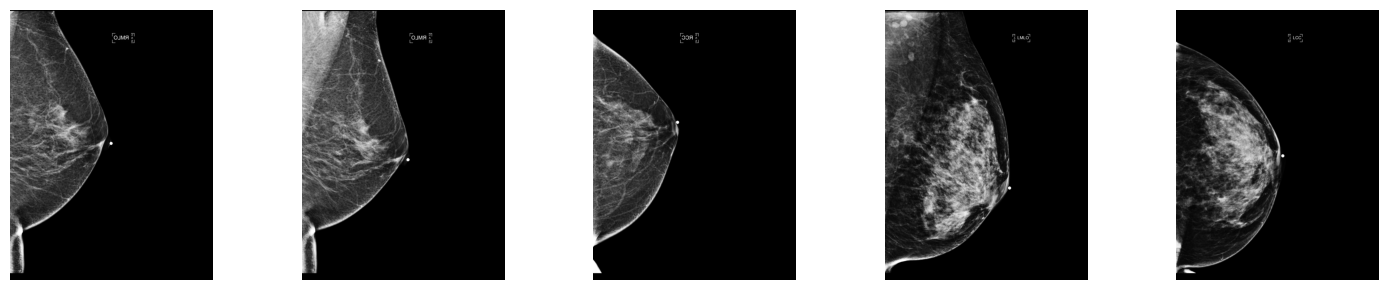

Model: Senograph 2000D ADS_17.4.5


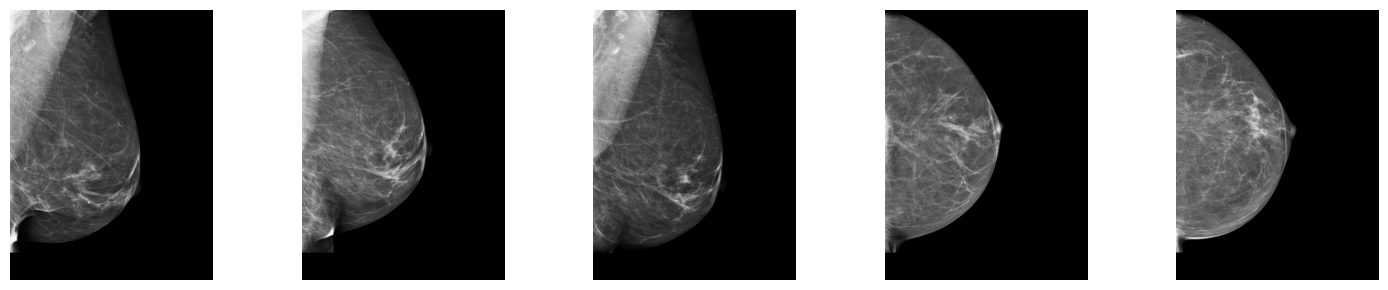

Model: Senograph 2000D ADS_17.5


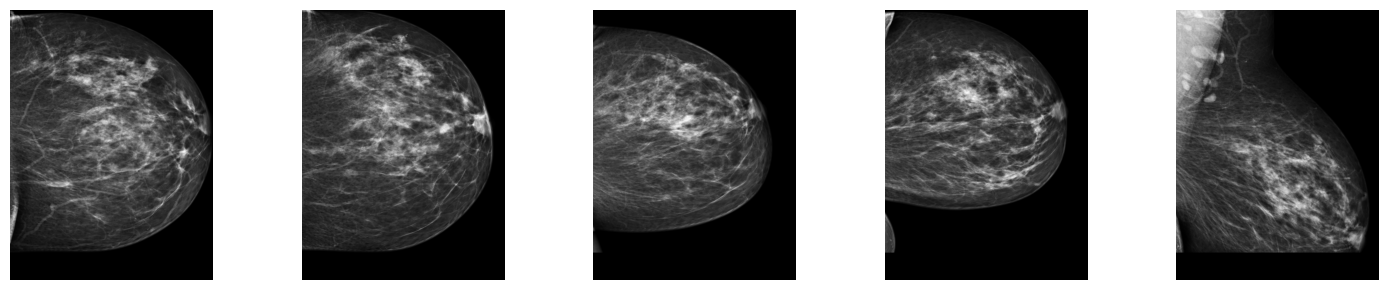

Model: Senographe Essential VERSION ADS_53.40


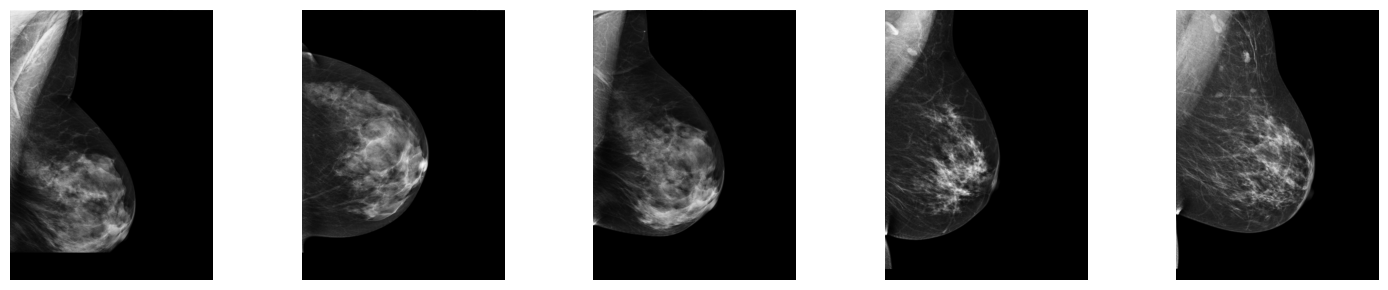

Model: Senographe Essential VERSION ADS_54.10


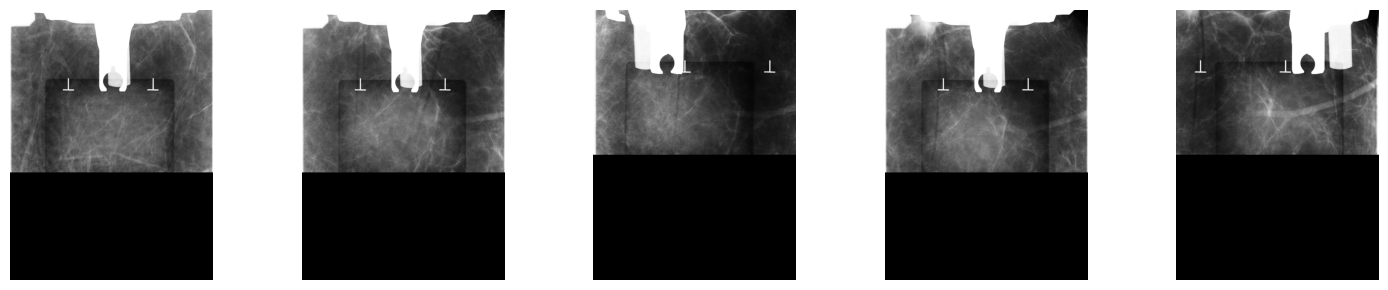

Model: Senographe Pristina


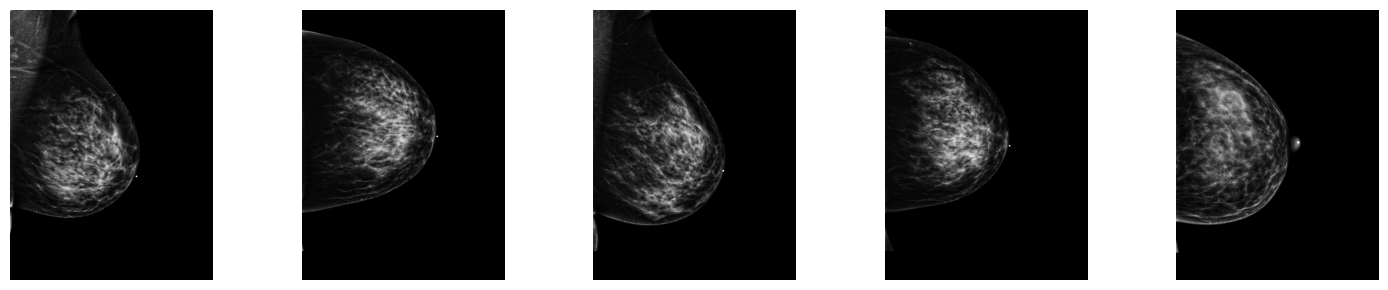

In [49]:
import matplotlib.pyplot as plt
from pathlib import Path
import matplotlib.image as mpimg

IMAGE_DIR = Path("/vol/biodata/data/Mammo/EMBED/images/png/1024x768")

# Group by ManufacturerModelName and iterate
for model_name, group in df.groupby("ManufacturerModelName"):
    print(f"Model: {model_name}")
    
    # Limit to first 5 images
    sample_paths = group["image_path"].head(5)
    
    # Plot images in a row
    fig, axes = plt.subplots(1, len(sample_paths), figsize=(15, 3))
    
    # Handle case where less than 5 images are available
    if len(sample_paths) == 1:
        axes = [axes]
    
    for ax, path in zip(axes, sample_paths):
        img = mpimg.imread(IMAGE_DIR / Path(path))
        ax.imshow(img,cmap="gray")
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()
